### IMPORTS
---

In [ ]:
## Install these packages if needeed
%pip install pandas
%pip install ydata-profiling
%pip install -U scikit-learn

In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_csv, DataFrame
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from src.utils import get_model, train_model, test_model, save_model

import warnings 
warnings. filterwarnings('ignore')

### DATA
---

In [2]:
data = read_csv(filepath_or_buffer='.data/term-deposit-marketing-2020.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

In [4]:
data.shape # Note : not a small dataset

(40000, 14)

In [5]:
data.info() # Good <> No missing-values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [6]:
data.describe(include="all") # only numerical attributes considered
# 50 % of customers have less than 39 years old, have <= 407$ balance 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
count,40000.000000,40000,40000,40000,40000,40000.000000,40000,40000,40000,40000.000000,40000,40000.000000,40000.000000,40000
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,11,NaN,NaN,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,no
freq,NaN,9383,24386,20993,39191,NaN,24031,33070,24914,NaN,13532,NaN,NaN,37104
mean,40.544600,NaN,NaN,NaN,NaN,1274.277550,NaN,NaN,NaN,16.017225,NaN,254.824300,2.882175,NaN
std,9.641776,NaN,NaN,NaN,NaN,2903.769716,NaN,NaN,NaN,8.278127,NaN,259.366498,3.239051,NaN
min,19.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,NaN
25%,33.000000,NaN,NaN,NaN,NaN,54.000000,NaN,NaN,NaN,8.000000,NaN,100.000000,1.000000,NaN
50%,39.000000,NaN,NaN,NaN,NaN,407.000000,NaN,NaN,NaN,17.000000,NaN,175.000000,2.000000,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1319.000000,NaN,NaN,NaN,21.000000,NaN,313.000000,3.000000,NaN


In [7]:
# Notes <> Attributes
# - marital : categorical, binary
# - education : categorical, ordinal
# - default : categorical, binary
# - housing : categorical, binary
# - loan : categorical, binary
# - month : categorical, ordinal
# - contact - categorical, multiple values possibles

In [8]:
data.value_counts(subset=['y'], normalize=True, dropna=True).to_frame() # Note : A huge data imbalance
# Note : ACC here is not a good metrics - but that is what is asked

,0
y,
no,0.9276
yes,0.0724


### EDA
----

In [9]:
profile = ProfileReport(df=data) # Note : duration is the feature with the highest correlation with y

In [10]:
profile.to_file(output_file='.data/eda.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
profile.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### MODELLING
---

#### Model Selection

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelBinarizer
from sklearn.model_selection import  StratifiedKFold, cross_validate
from typing import Literal, List
from sklearn.base import TransformerMixin
from tqdm import tqdm

In [4]:
# Define preprocessing steps
columns = {"numeric": ["age", "balance", "day", "duration", "campaign"],
           "nominal":["job", "marital", "default", "housing", "loan", "contact"],
           "ordinal": ["education", "month"]}
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder()),
    
    ]
)
ordinal_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder()),
    
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer,columns["numeric"]),
        ("cat", categorical_transformer, columns["nominal"]),
        ("ord", ordinal_transformer, columns["ordinal"])
    ]
)

In [12]:
def run_experiment(df : DataFrame, preprocessor: TransformerMixin, task : Literal['classifier', 'regressor'], eval_metrics: List[str], target : str = 'y') -> DataFrame:
    X, y = df.drop(target, axis=1), df[target]
    y = LabelBinarizer().fit_transform(y)
   
    models = get_model(task=task)

    experiment = []

    for model in tqdm(models):
        print(model)
        try:
            clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
            # print(clf)
            scores = cross_validate(estimator=clf, X=X, y=y, cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True), scoring=eval_metrics)
            # print(scores)
            avg_perf = [scores[f'test_{metric_name}'].mean() for metric_name in eval_metrics]

            experiment.append([model.__class__.__name__, *avg_perf])

        except ValueError as e:
            ...
    return DataFrame(data=experiment, columns=['Model', *eval_metrics])

##RUN
result = run_experiment(data, preprocessor,'classifier', eval_metrics=['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall'])
result

  0%|          | 0/30 [00:00<?, ?it/s]

BernoulliNB()


  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]

CategoricalNB()


  7%|▋         | 2/30 [00:01<00:21,  1.32it/s]

ComplementNB()


 10%|█         | 3/30 [00:02<00:17,  1.56it/s]

DecisionTreeClassifier()


 13%|█▎        | 4/30 [00:04<00:34,  1.34s/it]

DummyClassifier()


 17%|█▋        | 5/30 [00:05<00:26,  1.07s/it]

ExtraTreeClassifier()


 20%|██        | 6/30 [00:05<00:23,  1.01it/s]

ExtraTreesClassifier()


 23%|██▎       | 7/30 [00:27<02:54,  7.58s/it]

GaussianNB()


 27%|██▋       | 8/30 [00:27<01:59,  5.41s/it]

GaussianProcessClassifier()


 30%|███       | 9/30 [1:28:23<9:38:33, 1653.05s/it]

HistGradientBoostingClassifier()


 33%|███▎      | 10/30 [1:28:34<6:22:01, 1146.06s/it]

KNeighborsClassifier()


 37%|███▋      | 11/30 [1:28:41<4:12:29, 797.34s/it] 

LabelPropagation()


 40%|████      | 12/30 [1:40:22<3:50:26, 768.16s/it]

LabelSpreading()


 43%|████▎     | 13/30 [1:59:51<4:12:04, 889.68s/it]

LinearDiscriminantAnalysis()


 47%|████▋     | 14/30 [1:59:55<2:45:51, 621.98s/it]

LinearSVC()


 50%|█████     | 15/30 [2:00:30<1:51:18, 445.21s/it]

LogisticRegression()


 53%|█████▎    | 16/30 [2:00:34<1:12:53, 312.41s/it]

LogisticRegressionCV()


 57%|█████▋    | 17/30 [2:01:07<49:27, 228.26s/it]  

MLPClassifier()


 60%|██████    | 18/30 [2:06:46<52:17, 261.47s/it]

MultinomialNB()


 63%|██████▎   | 19/30 [2:06:47<33:35, 183.22s/it]

NearestCentroid()


 67%|██████▋   | 20/30 [2:06:49<21:28, 128.86s/it]

NuSVC()


 70%|███████   | 21/30 [2:06:50<13:34, 90.48s/it] 

PassiveAggressiveClassifier()


 73%|███████▎  | 22/30 [2:06:52<08:30, 63.87s/it]

Perceptron()


 77%|███████▋  | 23/30 [2:06:53<05:16, 45.24s/it]

QuadraticDiscriminantAnalysis()


 80%|████████  | 24/30 [2:06:55<03:13, 32.25s/it]

RadiusNeighborsClassifier()


 83%|████████▎ | 25/30 [2:07:25<02:36, 31.34s/it]

RandomForestClassifier()


 87%|████████▋ | 26/30 [2:08:24<02:38, 39.67s/it]

RidgeClassifier()


 90%|█████████ | 27/30 [2:08:25<01:24, 28.28s/it]

RidgeClassifierCV()


 93%|█████████▎| 28/30 [2:08:29<00:41, 20.72s/it]

SGDClassifier()


 97%|█████████▋| 29/30 [2:08:33<00:15, 15.99s/it]

SVC()


100%|██████████| 30/30 [2:12:24<00:00, 264.82s/it]


,Model,accuracy,balanced_accuracy,f1,precision,recall
0,BernoulliNB,0.919175,0.549577,0.173831,0.335361,0.117401
1,DecisionTreeClassifier,0.914850,0.693054,0.424336,0.415732,0.433704
2,DummyClassifier,0.927600,0.500000,0.000000,0.000000,0.000000
3,ExtraTreeClassifier,0.905200,0.636755,0.330081,0.338030,0.322857
4,ExtraTreesClassifier,0.932600,0.592945,0.295645,0.606972,0.195780
5,GaussianNB,0.891775,0.691121,0.379238,0.324394,0.456493
6,HistGradientBoostingClassifier,0.938750,0.697500,0.495322,0.614059,0.415403
7,KNeighborsClassifier,0.932075,0.636921,0.382962,0.558955,0.291791
8,LabelPropagation,0.920700,0.668509,0.405641,0.444066,0.373617
9,LabelSpreading,0.921125,0.668738,0.406929,0.447144,0.373617


### Handling the data imbalancement
---

In [ ]:
%conda install -c conda-forge imbalanced-learn

In [10]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

def run_experiment(df : DataFrame, preprocessor: TransformerMixin, task : Literal['classifier', 'regressor'], eval_metrics: List[str], target : str = 'y') -> DataFrame:
    X, y = df.drop(target, axis=1), df[target]
    y = LabelBinarizer().fit_transform(y)
   
    models = get_model(task=task)

    experiment = []

    for model in tqdm(models):
        print(model)
        try:
            clf = Pipeline(steps=[("preprocessor", preprocessor), ("smote", SMOTE()), ("classifier", model)])
            # print(clf)
            scores = cross_validate(estimator=clf, X=X, y=y, cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True), scoring=eval_metrics)
            # print(scores)
            avg_perf = [scores[f'test_{metric_name}'].mean() for metric_name in eval_metrics]

            experiment.append([model.__class__.__name__, *avg_perf])

        except ValueError as e:
            ...
    return DataFrame(data=experiment, columns=['Model', *eval_metrics])

##RUN
result = run_experiment(data, preprocessor,'classifier', eval_metrics=['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall'])
result

  0%|          | 0/30 [00:00<?, ?it/s]

BernoulliNB()


  3%|▎         | 1/30 [00:03<01:50,  3.81s/it]

CategoricalNB()


  7%|▋         | 2/30 [00:06<01:24,  3.01s/it]

ComplementNB()


 10%|█         | 3/30 [00:08<01:16,  2.82s/it]

DecisionTreeClassifier()


 13%|█▎        | 4/30 [00:27<03:55,  9.05s/it]

DummyClassifier()


 17%|█▋        | 5/30 [00:30<02:50,  6.81s/it]

ExtraTreeClassifier()


 20%|██        | 6/30 [00:34<02:21,  5.89s/it]

ExtraTreesClassifier()


 23%|██▎       | 7/30 [02:20<14:49, 38.69s/it]

GaussianNB()


 27%|██▋       | 8/30 [02:23<10:00, 27.30s/it]

GaussianProcessClassifier()


 30%|███       | 9/30 [29:34<3:05:00, 528.59s/it]

HistGradientBoostingClassifier()


 33%|███▎      | 10/30 [29:55<2:04:00, 372.03s/it]

KNeighborsClassifier()


 37%|███▋      | 11/30 [30:07<1:22:54, 261.81s/it]

LabelPropagation()


 40%|████      | 12/30 [2:24:42<11:22:01, 2273.40s/it]

LabelSpreading()


 43%|████▎     | 13/30 [6:39:09<29:19:25, 6209.73s/it]

LinearDiscriminantAnalysis()


 47%|████▋     | 14/30 [6:39:12<19:16:02, 4335.17s/it]

LinearSVC()


 50%|█████     | 15/30 [6:40:31<12:43:00, 3052.03s/it]

LogisticRegression()


 53%|█████▎    | 16/30 [6:40:35<8:18:03, 2134.57s/it] 

LogisticRegressionCV()


 57%|█████▋    | 17/30 [6:41:16<5:26:06, 1505.14s/it]

MLPClassifier()


 60%|██████    | 18/30 [6:46:10<3:48:12, 1141.02s/it]

MultinomialNB()


 63%|██████▎   | 19/30 [6:46:11<2:26:26, 798.77s/it] 

NearestCentroid()


 67%|██████▋   | 20/30 [6:46:13<1:33:16, 559.61s/it]

NuSVC()


 70%|███████   | 21/30 [7:38:47<3:20:45, 1338.38s/it]

PassiveAggressiveClassifier()


 73%|███████▎  | 22/30 [7:38:51<2:05:02, 937.87s/it] 

Perceptron()


 77%|███████▋  | 23/30 [7:38:55<1:16:42, 657.50s/it]

QuadraticDiscriminantAnalysis()


 80%|████████  | 24/30 [7:38:58<46:08, 461.34s/it]  

RadiusNeighborsClassifier()


 83%|████████▎ | 25/30 [7:39:50<28:12, 338.47s/it]

RandomForestClassifier()


 87%|████████▋ | 26/30 [7:42:48<19:20, 290.10s/it]

RidgeClassifier()


 90%|█████████ | 27/30 [7:42:51<10:11, 203.95s/it]

RidgeClassifierCV()


 93%|█████████▎| 28/30 [7:42:55<04:47, 143.98s/it]

SGDClassifier()


 97%|█████████▋| 29/30 [7:43:02<01:42, 102.99s/it]

SVC()


100%|██████████| 30/30 [8:04:02<00:00, 968.09s/it]


,Model,accuracy,balanced_accuracy,f1,precision,recall
0,BernoulliNB,0.770950,0.735345,0.304838,0.195345,0.693713
1,DecisionTreeClassifier,0.904750,0.715146,0.428611,0.379082,0.493439
2,DummyClassifier,0.927600,0.500000,0.000000,0.000000,0.000000
3,ExtraTreeClassifier,0.890625,0.665037,0.346765,0.305704,0.401252
4,ExtraTreesClassifier,0.928475,0.668557,0.424450,0.508273,0.364632
5,GaussianNB,0.549425,0.665607,0.205073,0.117598,0.801460
6,HistGradientBoostingClassifier,0.929775,0.795017,0.567934,0.512504,0.637441
7,KNeighborsClassifier,0.885925,0.811649,0.479425,0.358330,0.724797
8,LabelPropagation,NaN,NaN,NaN,NaN,NaN
9,LinearDiscriminantAnalysis,0.863175,0.803203,0.436909,0.311193,0.733077


#### Feature selection - SequentialFeatureSelector + CATEGORICALNB

<p>As we aim to identify the minimal set of features that can explain the target variable Y without manually setting or determining the minimum number of features needed to achieve a 73% accuracy, it's more convenient to consider feature selection methods such as Boruta, Recursive Feature Selection with cross-validation (RFECV), and Sequential Feature Selection (SFS). [Great news : Some of these approaches are greedy but we are lucky, the dataset is quite small..same as the feature space]

With a method like SFS, the search direction can be either backward or forward. Since our goal is to find a minimal set of features, it's advisable to use a backward selection, starting with the entire set of features and iteratively remove features that contribute less to the model's performance.

It's also worth noting that, thanks to exploratory data analysis (EDA) and the correlation matrix, we might have already considered exploring X1, X2, and X5 as potentially relevant features."

NOTE : I am using categoricalNB, because it seemas to overfit less from previous step.

</p>

In [5]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.naive_bayes import CategoricalNB
from sklearn.base import BaseEstimator

def select_features(X : DataFrame, y: DataFrame, estimator: BaseEstimator) -> SequentialFeatureSelector:
    return SequentialFeatureSelector(estimator=estimator, n_features_to_select="auto",scoring='accuracy', direction="backward").fit(X, y)


fs = select_features(X=X_train, y=y_train, estimator=CategoricalNB())

print(f"MOST IMPORTANT FEATURES: {fs.get_feature_names_out()}")

MOST IMPORTANT FEATURES: ['X1' 'X2' 'X5']


In [6]:
X_train, X_test = list(map(fs.transform, [X_train, X_test]))
print(X_train.shape, X_test.shape)

(100, 3) (26, 3)


In [7]:
results, fitted_models = run_experiment(partitions=[X_train,X_test, y_train, y_test], task=TYPE_TASK)
results

,MODEL,TRAIN ACC,TEST ACC,DURATION (SECONDS)
3,DecisionTreeClassifier,0.82,0.846154,0.006182
25,RandomForestClassifier,0.82,0.846154,0.599099
12,LabelSpreading,0.82,0.846154,0.007594
11,LabelPropagation,0.82,0.846154,0.012365
6,ExtraTreesClassifier,0.82,0.807692,0.412812
8,GaussianProcessClassifier,0.75,0.807692,0.009373
20,NuSVC,0.79,0.769231,0.015816
10,KNeighborsClassifier,0.71,0.769231,0.012657
24,RadiusNeighborsClassifier,0.70,0.769231,0.008663
5,ExtraTreeClassifier,0.82,0.769231,0.007755


#### Feature importance -- DECISION TREE CLASSIFIER

In [8]:
from sklearn.inspection import permutation_importance

BEST_FITTED_MODEL = fitted_models['DecisionTreeClassifier']
r = permutation_importance(BEST_FITTED_MODEL, X=X_train, y=y_train,
                           n_repeats=30,
                           random_state=SEED,
                           scoring='accuracy')

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{fs.get_feature_names_out()[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

X5      0.250 +/- 0.043
X1      0.201 +/- 0.035
X2      0.193 +/- 0.034


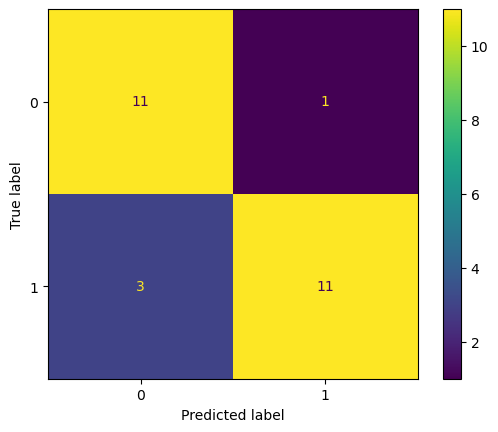

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = BEST_FITTED_MODEL.predict(X_test)
conf_mat  = confusion_matrix(y_true=y_test, y_pred=predictions)

ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()

#### Classification report

In [11]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predictions, output_dict=True)
df_classification_report = DataFrame(report).transpose()
df_classification_report.sort_values(by=['f1-score'], ascending=False, inplace=True)
df_classification_report

,precision,recall,f1-score,support
0,0.785714,0.916667,0.846154,12.000000
1,0.916667,0.785714,0.846154,14.000000
accuracy,0.846154,0.846154,0.846154,0.846154
macro avg,0.851190,0.851190,0.846154,26.000000
weighted avg,0.856227,0.846154,0.846154,26.000000


#### SAVE MODEL
---

In [12]:
save_model(fitted_model=BEST_FITTED_MODEL, filepath='acme_best_model.jb')